In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, sum as ndi_sum, center_of_mass
import os
from scipy.ndimage import uniform_filter1d
# --- Main Simulation Function ---
def run_simulation(lam=0.5, zeta=-1.0, R1=10, R2=6, steps= 5000, dt=0.001, save_interval=100):
    np.random.seed(0)

    # Grid setup
    N = 256
    L = 128.0
    dx = L / N
    x = np.arange(N) * dx - L / 2
    y = np.arange(N) * dx - L / 2
    X, Y = np.meshgrid(x, y, indexing="ij")

    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    K2 = KX**2 + KY**2
    dealias = K2 < (0.67 * K2.max())

    fft = np.fft.fft2
    ifft = lambda f: np.fft.ifft2(f).real

    A, B, K = 1.0, 1.0, 1.0
    sep = 30

    # Initialize two droplets
    phi = -0.9 * np.ones((N, N))
    phi[(X + sep)**2 + Y**2 < R1**2] = 1.0
    phi[(X - sep)**2 + Y**2 < R2**2] = 1.0
    phi += 0.01 * np.random.randn(*phi.shape)
    f_phi = fft(phi)

    radii_history = []

    for step in range(steps + 1):
        phi = np.clip(ifft(f_phi), -2.0, 2.0)

        if not np.isfinite(phi).all():
            print(f"NaN at step {step}")
            break

        if step % save_interval == 0:
            binary = (phi > 0.0).astype(int)
            labeled, num = label(binary)
            areas = ndi_sum(binary, labeled, index=range(1, num + 1))
            COMs = center_of_mass(binary, labeled, index=range(1, num + 1))

            blob_data = [(a, com) for a, com in zip(areas, COMs) if a > 10]
            r_left = r_right = 0.0

            if len(blob_data) >= 1:
                blob_data.sort(key=lambda b: b[1][0])
                if len(blob_data) >= 2:
                    r_left = np.sqrt(blob_data[0][0] / np.pi)
                    r_right = np.sqrt(blob_data[1][0] / np.pi)
                else:
                    x_idx = int(round(blob_data[0][1][0]))
                    x_pos = (x_idx - N // 2) * dx
                    r = np.sqrt(blob_data[0][0] / np.pi)
                    if x_pos < 0:
                        r_left = r
                    else:
                        r_right = r

            radii_history.append((r_left, r_right))
        

        # Compute gradients and update
        dphi_dx = ifft(1j * KX * f_phi)
        dphi_dy = ifft(1j * KY * f_phi)
        grad_phi2 = np.clip(dphi_dx**2 + dphi_dy**2, 0, 100)

        lap_phi = ifft(-K2 * f_phi)
        mu = -A * phi + B * phi**3 - K * lap_phi + lam * grad_phi2
        f_mu = fft(mu)

        Jzeta = 1j * KX * fft(lap_phi * dphi_dx) + 1j * KY * fft(lap_phi * dphi_dy)

        dfdt = -K2 * f_mu - zeta * Jzeta
        dfdt = np.clip(dfdt, -1e4, 1e4)
        dfdt *= dealias
        f_phi += dt * dfdt
        radii_smooth = uniform_filter1d(np.array(radii_history), size=5, axis=0)
    # Analyze growth to classify region
    arr = np.array(radii_history)
    if len(arr) == 0:
        region = "Undetermined"
    else:
        growL = arr[-1, 0] - arr[0, 0]
        growR = arr[-1, 1] - arr[0, 1]
        if growL > 0.2 and growR < -0.2:
            region = "A"  # Forward ripening
        elif growR > 0.2 and growL < -0.2:
            region = "B"  # Reverse ripening
        elif growL > 0.2 and growR > 0.2:
            region = "C"  # Both grow
        else:
            region = "Undetermined"

    print(f"Done: λ={lam}, ζ={zeta} → Region {region}")
    return np.array(radii_history), region


Done: λ=0.5, ζ=-1 → Region Undetermined


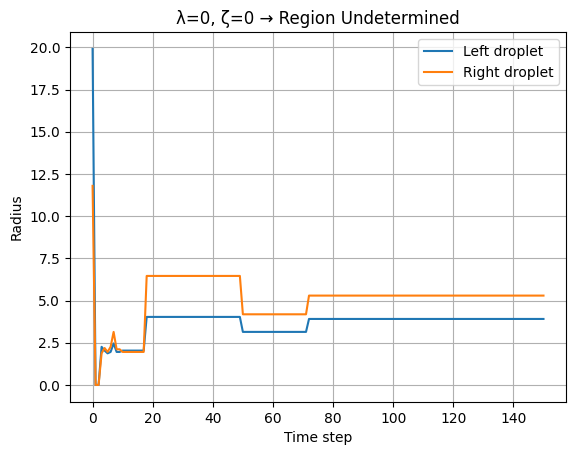

In [13]:
# Run one simulation
radii, region = run_simulation(
    lam=0.5,
    zeta=-1,
    steps=15000,  # short test
    dt=0.001,    # smaller dt for stability
)


# Plot the result
plt.plot(radii[:, 0], label="Left droplet")
plt.plot(radii[:, 1], label="Right droplet")
plt.xlabel("Time step")
plt.ylabel("Radius")
plt.title(f"λ=0, ζ=0 → Region {region}")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\anuhe\AppData\Local\Temp\ipykernel_2200\3197450484.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  S0 = np.trapz(grad2, y)
C:\Users\anuhe\AppData\Local\Temp\ipykernel_2200\3197450484.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  S1 = np.trapz(grad2 * np.exp(exponent), y)


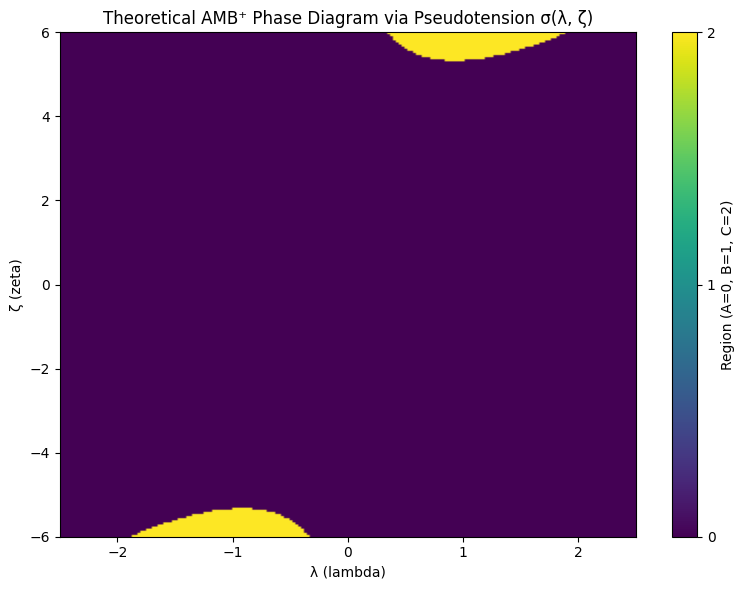

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = 1.0
K = 1.0
xi = np.sqrt(K / (2 * A))

# Grid for interface
y = np.linspace(-10 * xi, 10 * xi, 1000)
phi = np.tanh(y / np.sqrt(2 * xi))
dphi = np.gradient(phi, y)

# Phase diagram grid
lams = np.linspace(-2.5, 2.5, 201)
zetas = np.linspace(-6.0, 6.0, 241)
region_map = np.empty((len(lams), len(zetas)), dtype=str)

def compute_sigma(lam, zeta, phi, dphi, y):
    grad2 = dphi**2
    S0 = np.trapz(grad2, y)
    exponent = (zeta - 2 * lam) * phi / K
    S1 = np.trapz(grad2 * np.exp(exponent), y)
    denom = zeta - 2 * lam
    if np.abs(denom) < 1e-6:
        return np.nan  # avoid divide-by-zero
    return (K / denom) * (zeta * S0 - 2 * lam * S1)

def classify_region(sig_droplet, sig_bubble):
    if sig_droplet > 0 and sig_bubble > 0:
        return "A"
    elif sig_droplet < 0 and sig_bubble > 0:
        return "B"
    elif sig_droplet < 0 and sig_bubble < 0:
        return "C"
    else:
        return "?"

# Sweep through (λ, ζ) grid
for i, lam in enumerate(lams):
    for j, zeta in enumerate(zetas):
        sig_drop = compute_sigma(lam, zeta, phi, dphi, y)
        sig_bubb = compute_sigma(lam, zeta, -phi, -dphi, y)
        region = classify_region(sig_drop, sig_bubb)
        region_map[i, j] = region

# Plotting
region_colors = {'A': 0, 'B': 1, 'C': 2, '?': -1}
Z = np.vectorize(region_colors.get)(region_map)

plt.figure(figsize=(8, 6))
plt.imshow(Z.T, origin="lower", extent=(lams[0], lams[-1], zetas[0], zetas[-1]),
           aspect="auto", cmap="viridis", vmin=0, vmax=2)
plt.colorbar(ticks=[0, 1, 2], label="Region (A=0, B=1, C=2)")
plt.xlabel("λ (lambda)")
plt.ylabel("ζ (zeta)")
plt.title("Theoretical AMB⁺ Phase Diagram via Pseudotension σ(λ, ζ)")
plt.grid(False)
plt.tight_layout()
plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, sum as ndi_sum, center_of_mass, uniform_filter1d

# --- Main Simulation Function ---
def run_simulation(lam=0.5, zeta=-1.0, R1=10, R2=6, steps=5000, dt=0.001, save_interval=100):
    np.random.seed(0)

    # Grid setup
    N = 256
    L = 128.0
    dx = L / N
    x = np.arange(N) * dx - L / 2
    y = np.arange(N) * dx - L / 2
    X, Y = np.meshgrid(x, y, indexing="ij")

    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    K2 = KX**2 + KY**2
    dealias = K2 < (0.67 * K2.max())

    fft = np.fft.fft2
    ifft = lambda f: np.fft.ifft2(f).real

    A, B, K = 1.0, 1.0, 1.0
    sep = 30

    # Initialize two droplets
    phi = -0.9 * np.ones((N, N))
    phi[(X + sep)**2 + Y**2 < R1**2] = 1.0
    phi[(X - sep)**2 + Y**2 < R2**2] = 1.0
    phi += 0.01 * np.random.randn(*phi.shape)
    f_phi = fft(phi)

    radii_history = []

    for step in range(steps + 1):
        phi = np.clip(ifft(f_phi), -2.0, 2.0)

        if not np.isfinite(phi).all():
            print(f"NaN at step {step}")
            break

        if step % save_interval == 0:
            binary = (phi > 0.0).astype(int)  # capture whole droplet
            labeled, num = label(binary)
            areas = ndi_sum(binary, labeled, index=range(1, num + 1))
            COMs = center_of_mass(binary, labeled, index=range(1, num + 1))

            blob_data = [(a, com) for a, com in zip(areas, COMs) if a > 10]
            r_left = r_right = 0.0

            if len(blob_data) >= 1:
                blob_data.sort(key=lambda b: b[1][0])
                if len(blob_data) >= 2:
                    r_left = np.sqrt(blob_data[0][0] / np.pi)
                    r_right = np.sqrt(blob_data[1][0] / np.pi)
                else:
                    x_idx = int(round(blob_data[0][1][0]))
                    x_pos = (x_idx - N // 2) * dx
                    r = np.sqrt(blob_data[0][0] / np.pi)
                    if x_pos < 0:
                        r_left = r
                    else:
                        r_right = r

            radii_history.append((r_left, r_right))

        # Compute gradients and update
        dphi_dx = ifft(1j * KX * f_phi)
        dphi_dy = ifft(1j * KY * f_phi)
        grad_phi2 = np.clip(dphi_dx**2 + dphi_dy**2, 0, 100)

        lap_phi = ifft(-K2 * f_phi)
        mu = -A * phi + B * phi**3 - K * lap_phi + lam * grad_phi2
        f_mu = fft(mu)

        Jzeta = 1j * KX * fft(lap_phi * dphi_dx) + 1j * KY * fft(lap_phi * dphi_dy)

        dfdt = -K2 * f_mu - zeta * Jzeta
        dfdt = np.clip(dfdt, -1e4, 1e4)
        dfdt *= dealias
        f_phi += dt * dfdt

    # --- Classification ---
    arr = np.array(radii_history)
    if len(arr) == 0:
        region = "Undetermined"
    else:
        growL = arr[-1, 0] - arr[0, 0]
        growR = arr[-1, 1] - arr[0, 1]
        if growL > 0.2 and growR < -0.2:
            region = "A"  # Forward Ostwald
        elif growR > 0.2 and growL < -0.2:
            region = "B"  # Reverse Ostwald
        elif growL > 0.2 and growR > 0.2:
            region = "C"  # Both grow (unstable)
        else:
            region = "Undetermined"

    print(f"Done: λ={lam}, ζ={zeta} → Region {region}")
    return np.array(radii_history), region, lam, zeta


Done: λ=0.5, ζ=-1.0 → Region Undetermined


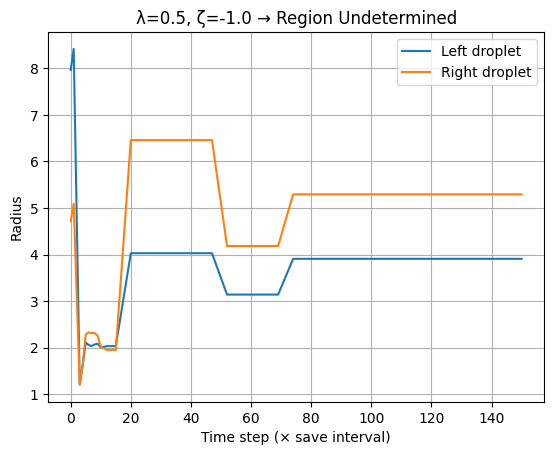

In [17]:
# Run the simulation
radii, region, lam, zeta = run_simulation(
    lam=0.5,
    zeta=-1.0,
    steps=15000,
    dt=0.001,
)

# Smooth and plot
radii_smooth = uniform_filter1d(radii, size=5, axis=0)

plt.plot(radii_smooth[:, 0], label="Left droplet")
plt.plot(radii_smooth[:, 1], label="Right droplet")
plt.xlabel("Time step (× save interval)")
plt.ylabel("Radius")
plt.title(f"λ={lam}, ζ={zeta} → Region {region}")
plt.legend()
plt.grid(True)
plt.show()


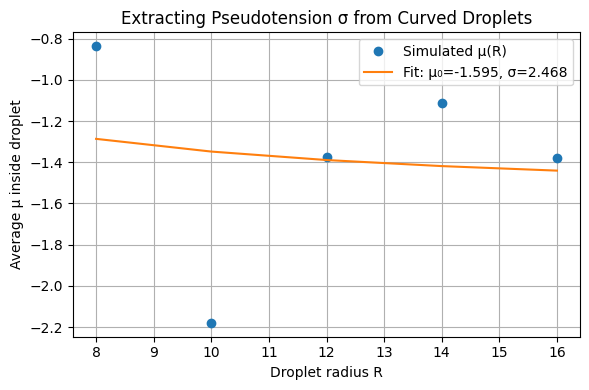

Extracted pseudotension σ ≈ 2.4684
Fitted bulk chemical potential μ₀ ≈ -1.5947


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq
from scipy.optimize import curve_fit

# --- Parameters ---
N = 256
L = 128.0
dx = L / N
x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, y, indexing="ij")

kx = fftfreq(N, d=dx) * 2 * np.pi
ky = fftfreq(N, d=dx) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky, indexing="ij")
K2 = KX**2 + KY**2
K2[0, 0] = 1e-6  # avoid div by zero

# --- Model parameters ---
A = 1.0
B = 1.0
K = 1.0
lam = 0.5
zeta = -1.0

def initialize_droplet(radius):
    phi = -0.9 * np.ones((N, N))
    mask = (X**2 + Y**2) < radius**2
    phi[mask] = 1.0
    return phi

def compute_mu(phi):
    dphi_dx = np.real(ifft2(1j * KX * fft2(phi)))
    dphi_dy = np.real(ifft2(1j * KY * fft2(phi)))
    grad_phi2 = dphi_dx**2 + dphi_dy**2

    lap_phi = np.real(ifft2(-K2 * fft2(phi)))

    mu = -A * phi + B * phi**3 - K * lap_phi + lam * grad_phi2

    lap_phi_dx = lap_phi * dphi_dx
    lap_phi_dy = lap_phi * dphi_dy
    Jzeta = 1j * KX * fft2(lap_phi_dx) + 1j * KY * fft2(lap_phi_dy)
    Jzeta_real = np.real(ifft2(Jzeta))
    
    mu -= zeta * Jzeta_real
    return mu

# --- Compute for multiple droplet radii ---
radii = np.array([8, 10, 12, 14, 16])
mu_avg = []

for R in radii:
    phi = initialize_droplet(R)
    mu_field = compute_mu(phi)
    mask = (X**2 + Y**2) < (R - 1)**2  # exclude edges
    mu_in = np.mean(mu_field[mask])
    mu_avg.append(mu_in)

mu_avg = np.array(mu_avg)

# --- Fit μ(R) = μ₀ + σ/R ---
def fit_func(R, mu0, sigma):
    return mu0 + sigma / R

params, _ = curve_fit(fit_func, radii, mu_avg)
mu0_fit, sigma_fit = params

# --- Plot ---
plt.figure(figsize=(6,4))
plt.plot(radii, mu_avg, 'o', label='Simulated μ(R)')
plt.plot(radii, fit_func(radii, *params), '-', label=f'Fit: μ₀={mu0_fit:.3f}, σ={sigma_fit:.3f}')
plt.xlabel("Droplet radius R")
plt.ylabel("Average μ inside droplet")
plt.title("Extracting Pseudotension σ from Curved Droplets")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- Output ---
print(f"Extracted pseudotension σ ≈ {sigma_fit:.4f}")
print(f"Fitted bulk chemical potential μ₀ ≈ {mu0_fit:.4f}")
